In [1]:
# Декоратор, подавляющий варны у sklearn связанные с внутренними багами
import warnings
from functools import wraps

def ignore_warnings(f):
    @wraps(f)
    def inner(*args, **kwargs):
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("ignore")
            response = f(*args, **kwargs)
        return response
    return inner

In [2]:
# Импорт основных либ
import sklearn
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import stream as st

In [3]:
# Чтение данных метилирования и установка рандом стейта
values = (np.load("../BIO_Ml/GSE52588/GSE52588_beta_fn.npz"))["X"]
data = pd.read_csv("../BIO_Ml/GSE52588/GSE52588_samples.csv", delim_whitespace=True)
rand_state = 42

1.1


In [4]:
# Чтение данных о возрасте, соответствия генам
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = cpg_names["ID_REF"]
cpg_names = cpg_names.replace(np.nan, "0")
x_cpg = pd.DataFrame(data=values, columns=cpg_names[:422802])
x_cpg["Age"] = data["age"]
x_cpg["Gene_Name"] = gene_names["UCSC_REFGENE_NAME"]

In [5]:
# Обрезка по здоровым людям
y = x_cpg["Age"]
#y = y.to_numpy()
X = x_cpg.drop(["Age", "Gene_Name"], axis=1)
X.columns.name = None
y = y[29:]
X = X[29:]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
#X = Normalizer().fit_transform(X)

C:\Users\Eugen\AppData\Local\Temp/ipykernel_2880/2493085721.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Graphs/general_density.png", ppi = 400)


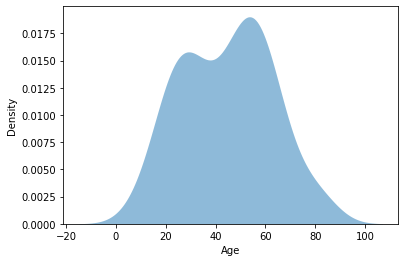

In [6]:
# Построение распределения по выборке
sns.kdeplot(data=y,
            fill=True,
            alpha=0.5,
            palette="crest",
            linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.savefig("Graphs/general_density.png", ppi = 400)
plt.show()

In [7]:
# отбор важных признаков
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector_k = SelectKBest(score_func=f_regression, k=42)
fit = selector_k.fit(X, y)
cols = selector_k.get_support(indices=True)
X = X.iloc[:, cols]
#X = fit.transform(X)
#X.to_csv('out.zip', index=False, compression="zip")

In [8]:
# STREAM data prep
#print(st.__version__)
#column_lables = pd.DataFrame(data=X.columns)
#column_lables.to_csv("column_lables.csv", index=False, header=False)

In [9]:
# Запуск STREAM
# adata = st.read(file_name='out.csv',delimiter=',')
# st.add_cell_labels(adata,file_name='column_lables.csv')
#
# st.plot_visualization_2D(adata, method="umap", n_neighbors=10)
# st.seed_elastic_principal_graph(adata, n_clusters=10,use_vis=True)
# st.plot_dimension_reduction(adata,n_components=2,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=True)

In [10]:
# Отрисовать график на выбор по индексу
feature = 12
ox = y
oy = X.iloc[:, feature]

In [11]:
# Отбор топ признаков
t_df = X
t_df["Age"] = y

i = 0
while i < 4:
    loc_corr = abs(np.around(np.corrcoef(ox, t_df.iloc[:, i])[0,1], 3))
    if (loc_corr < 0.9) and (loc_corr > -0.9) :
        t_df = t_df.drop(t_df.columns[i], axis=1)
        continue
    i+=1

corr = t_df.corr()
corr.style.background_gradient(cmap='coolwarm',
                               vmin=-1,
                               vmax=1)

,cg02711724,cg02711726,cg06931676,Age
cg02711724,1.000000,0.955476,0.865237,0.904374
cg02711726,0.955476,1.000000,0.896174,0.913695
cg06931676,0.865237,0.896174,1.000000,0.940773
Age,0.904374,0.913695,0.940773,1.000000


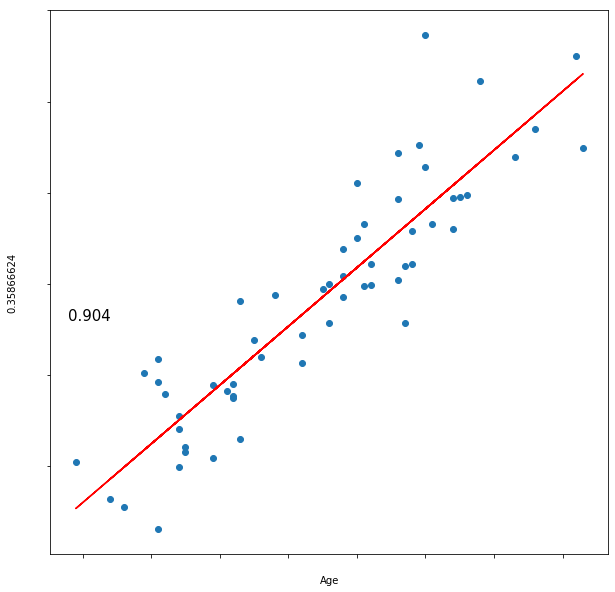

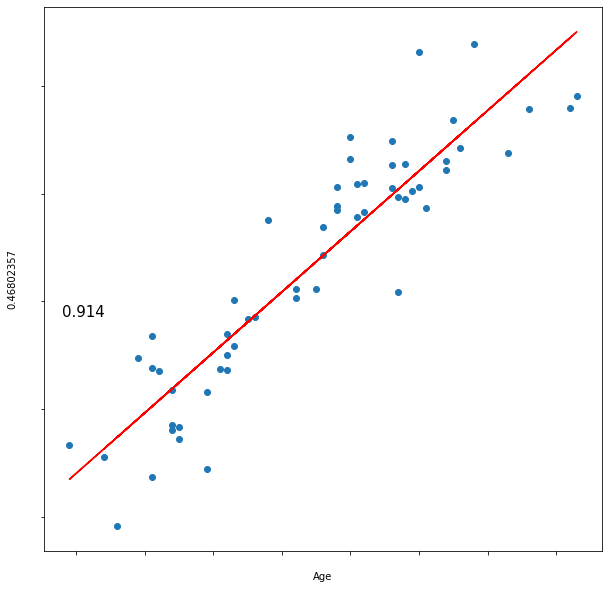

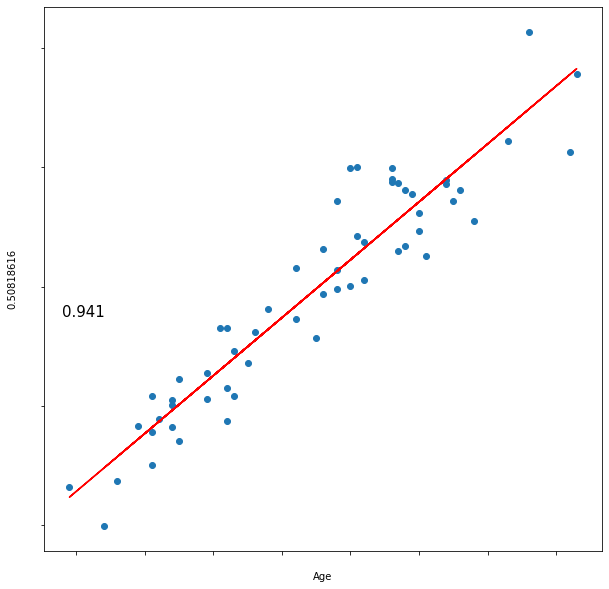

In [12]:
# отрисовка корреляции топ-n признаков с возрастом + регрессия
for i in range(i-1):
    oy = t_df.iloc[:, i]
    fig = plt.figure()
    ax = plt.axes()
    m, b = np.polyfit(ox, oy, 1)
    fig.text(0.15, 0.45,
             s=np.around(np.corrcoef(ox,oy)[0,1], 3),
             fontsize=15)
    ax.plot(ox, m * ox + b, c="r")
    ax.scatter(ox, oy)
    plt.xlabel("Age")
    plt.ylabel(oy[0])
    plt.savefig("Graphs/corr_cpg_to_age" + str(i) + ".png")
    plt.gca().tick_params(labelcolor="#ffffff")
    #fig.show

In [13]:
X = X.drop(["Age"], axis=1)

C:\Users\Eugen\AppData\Local\Temp/ipykernel_2880/3822101717.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Graphs/3d_on_2d_cpg.png", ppi = 400)
C:\Users\Eugen\AppData\Local\Temp/ipykernel_2880/3822101717.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


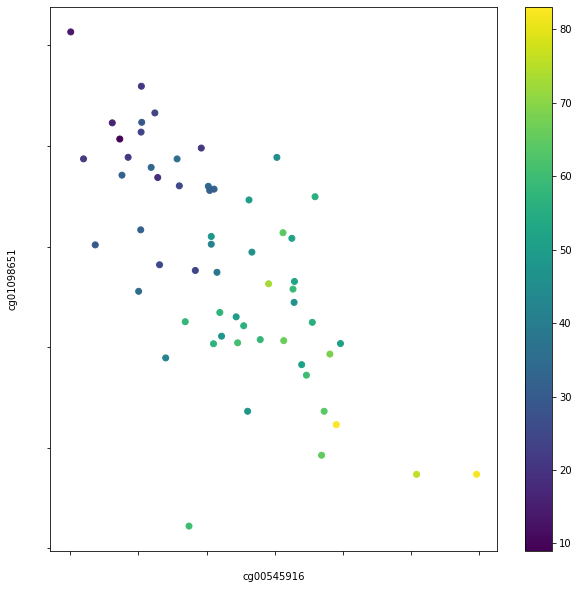

In [14]:
# Отображение на плоскость
fig3 = plt.figure()
ax = plt.axes()
cpg1 = X.iloc[:, 0]
cpg2 = X.iloc[:, 1]

image = ax.scatter(cpg1, cpg2, c=y)
fig3.colorbar(image, ax=ax)
df_columns = X.columns

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel(df_columns[0])
plt.ylabel(df_columns[1])
plt.savefig("Graphs/3d_on_2d_cpg.png", ppi = 400)
plt.gca().tick_params(labelcolor="#ffffff")
fig3.show()

In [15]:
# Запись генов в файл
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
gene_names = gene_names[["ID_REF", "UCSC_REFGENE_NAME"]]
gene_names = gene_names.replace(np.nan, "0")

important_cpgs = list(X.columns)
gene_names = gene_names[gene_names["ID_REF"].isin(important_cpgs)]
gene_names = gene_names.drop(gene_names[gene_names["UCSC_REFGENE_NAME"] == "0"].index).drop_duplicates()
gene_names = gene_names["UCSC_REFGENE_NAME"].drop_duplicates()

for i in range(len(gene_names)):
    gene_names.iloc[i] = set(gene_names.iloc[i].split(";"))

gene_names = gene_names.reset_index()
gene_names = gene_names["UCSC_REFGENE_NAME"]
# gene_names.to_excel("gene_names_CpG_based.xlsx", index = False)

In [16]:
# К-фолд для проверки устойчивости модели
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev

regressor = SVR(kernel="poly", C=1.5)
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand_state)
lst_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    regressor.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(regressor.score(x_test_fold, y_test_fold))

print('List of possible SDs: ', lst_accu_stratified)
print('\nMean SD is: ', mean(lst_accu_stratified))

List of possible SDs:  [0.9201850211084928, 0.9133288373843053]

Mean SD is:  0.9167569292463991


c:\users\eugen\pycharmprojects\python_study\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


C:\Users\Eugen\AppData\Local\Temp/ipykernel_2880/3382680724.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Graphs/train_test_density.png", ppi = 400)


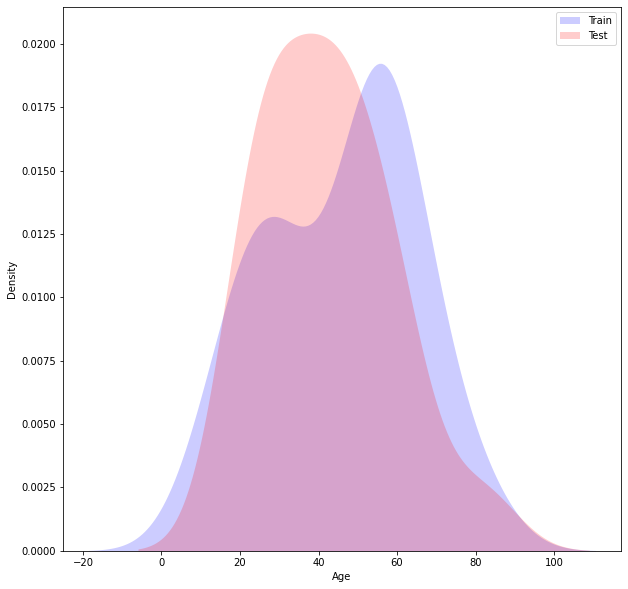

In [17]:
# Разбиение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand_state)
sns.kdeplot(y_train, color='b', fill=True, alpha=.2, linewidth=0)
sns.kdeplot(y_test, color="r", fill=True, alpha=.2, linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["Train", "Test"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.savefig("Graphs/train_test_density.png", ppi = 400)

plt.show()

In [18]:
# Построение модели
regressor = SVR(kernel="poly", C=1.4)
model = regressor.fit(X_train, y_train)

In [19]:
# Предсказание и экспорт
y_pred = regressor.predict(X_test)
res = pd.DataFrame({"Actual": y_test, "Predicted": y_pred,
                    "AE": y_test - y_pred,
                    "SE": (y_test - y_pred) ** 2})
print("MAE: ", mean_absolute_error(y_test, y_pred),
      "MSE: ", mean_squared_error(y_test, y_pred),
      "R2 ", r2(y_test, y_pred))
res.to_excel("results.xlsx", index = False)
print(res)


MAE:  3.0042329728010513 MSE:  12.848384903824435 R2  0.9495726484405808
    Actual  Predicted        AE         SE
0       21  25.699202 -4.699202  22.082496
5       24  24.895142 -0.895142   0.801279
34      56  64.090764 -8.090764  65.460465
13      36  32.559218  3.440782  11.838982
44      46  44.963241  1.036759   1.074869
52      61  55.167381  5.832619  34.019445
37      64  62.088699  1.911301   3.653073
25      33  30.063501  2.936499   8.623028
46      45  41.410780  3.589220  12.882502
12      32  29.767887  2.232113   4.982327
48      82  76.503350  5.496650  30.213160
3       21  23.456340 -2.456340   6.033605
36      51  55.886419 -4.886419  23.877092
31      42  43.253941 -1.253941   1.572369
8       33  31.613307  1.386693   1.922918
17      24  22.190380  1.809620   3.274724
6       25  24.723735  0.276265   0.076322
4       42  45.733894 -3.733894  13.941964
41      56  57.023858 -1.023858   1.048285
19      48  51.096578 -3.096578   9.588792


  0%|          | 0/20 [00:00<?, ?it/s]

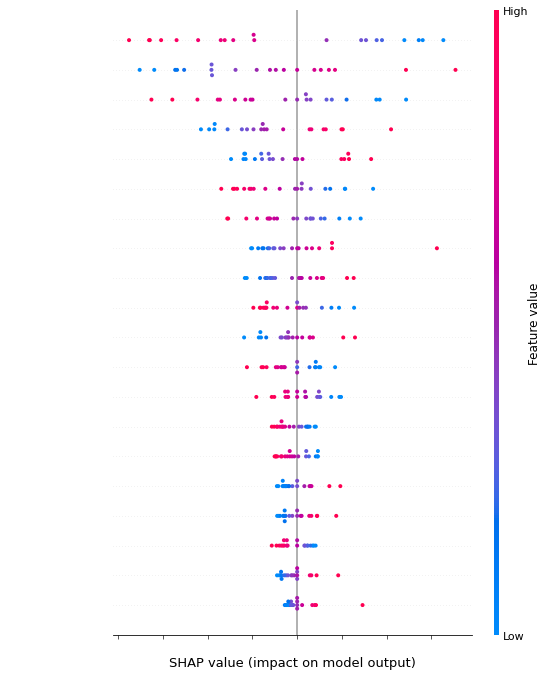

In [20]:
# Работа с ШАПом
import shap
from _beeswarm import summary_legacy
X_train_summary = shap.kmeans(X_train, 10)

@ignore_warnings
def kernel_explain(X_train_summary, regressor, X_test):
    ex = shap.KernelExplainer(regressor.predict, X_train_summary)
    shap_values = ex.shap_values(X_test)
    return shap_values, ex

shap_values, ex = kernel_explain(X_train_summary, regressor, X_test)
nnan_values_to_plot = summary_legacy(shap_values, X_test, show=False, plot_type="dot")
#shap.summary_plot(shap_values, X_test, show=False, plot_type="dot")
plt.tight_layout()
#plt.savefig("Graphs/shap_explanation_sumplot_1.png")
plt.show()

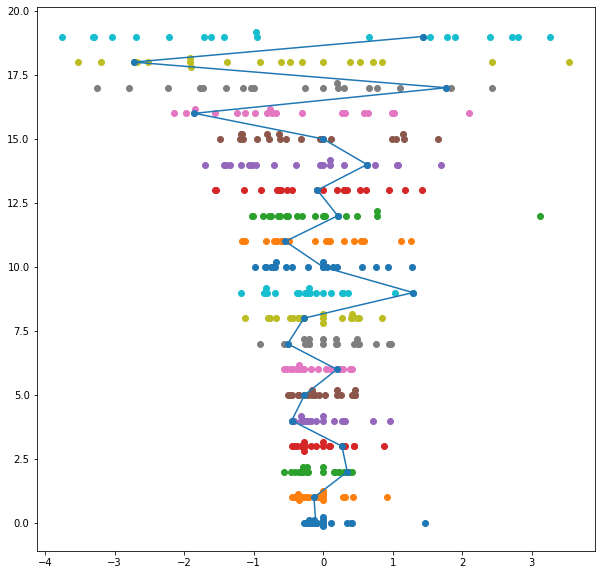

In [53]:
# Использоавние _инорфмации ШАПа для потсроения профиля по человеку
id = 0
for i in range(20):
    plt.scatter(nnan_values_to_plot[i][0], nnan_values_to_plot[i][1])
person_x = []
person_y = []
for i in range(20):
    person_x.append(nnan_values_to_plot[i][0][id])
    person_y.append(nnan_values_to_plot[i][1][id])
plt.plot(person_x, person_y, "-o")
plt.show()

1.0.1


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


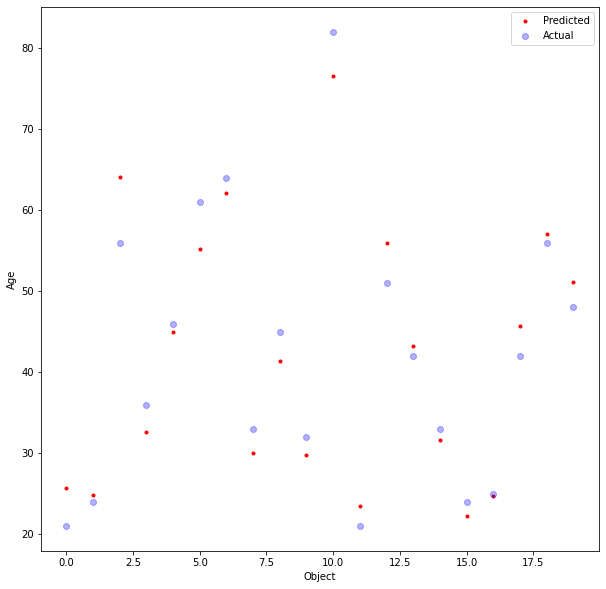

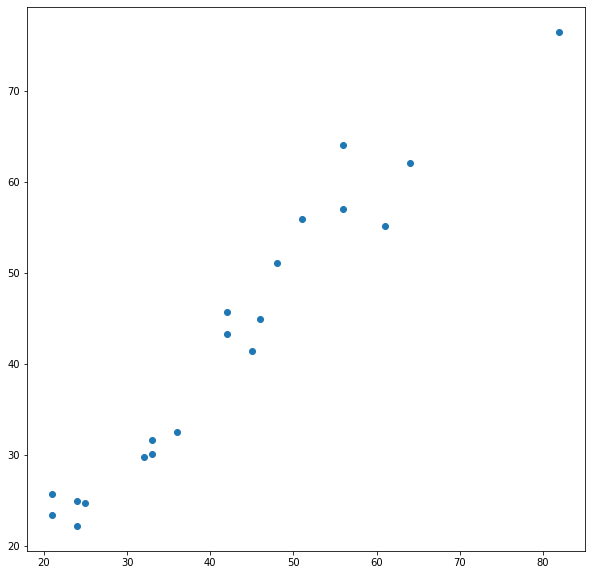

In [55]:
# Построение графика "попаданий"
y_test = y_test.to_numpy()
fig4 = plt.figure()
ax = plt.axes()

plt.plot(y_pred, ".", c="r")
plt.plot(y_test, "o", c="b", alpha=0.3)
plt.xlabel("Object")
plt.ylabel("Age")
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["Predicted", "Actual"])
plt.savefig("Graphs/result.png")

fig4.show()
print(sklearn.__version__)